In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import trange
import warnings

from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel, SequentialFeatureSelector, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

n_cpu = os.cpu_count()
seed = 24

warnings.filterwarnings('ignore')

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Load Data and Preprocessing

In [3]:
dataset_name = 'UNSW_NB15'

In [4]:
train_raw = pd.read_csv(f'./Data/{dataset_name}/train.csv')
print(train_raw.info())
test_raw = pd.read_csv(f'./Data/{dataset_name}/test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [5]:
col_drop = []
for col in train_raw.columns:
    if train_raw[col].value_counts().shape[0] == 1:
        col_drop.append(col)

print(col_drop)

[]


## NSLKDD

In [5]:
train_X = train_raw.drop(['class', 'num_outbound_cmds'], axis=1).select_dtypes(include='number')
train_Y = train_raw['class'].map({'normal': 1, 'anomaly': 0})
test_X = test_raw.drop(['class', 'num_outbound_cmds'], axis=1).select_dtypes(include='number')
test_Y = test_raw['class'].map({'normal': 1, 'anomaly': 0})
test_X = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
test_X = test_X.clip(0, 1)
train_X = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
print(train_X.shape, test_X.shape)

(125973, 37) (22544, 37)


## UNSW-NB15

In [6]:
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['label']
test_X = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
test_X = test_X.clip(0, 1)
train_X = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
print(train_X.shape, test_X.shape)

(82332, 39) (175341, 39)


# Feature Selection

## Correlation-Based

In [7]:
correlation_matrix = train_X.corr()
model = RandomForestClassifier(n_estimators=200, n_jobs=n_cpu-1, random_state=seed)
selected_features = []

original_features = train_X.columns.tolist()
print(original_features)
start_time = time.time()
while len(original_features) > 0:
    indices = correlation_matrix[correlation_matrix.loc[:, original_features[0]] >= 0.8].index.tolist()
    print(indices)
    if len(indices) == 1:
        selected_features.append(indices[0])
        original_features.remove(indices[0])
        continue

    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    selector.fit(train_X[indices], train_Y)
    selected_features.append([b for a, b in zip(selector.get_support(), indices) if a][0])
    original_features = [col for col in original_features if col not in indices]

print(f'time cost: {time.time()-start_time}')
print(f'selected features: {selected_features}')

train_X = train_X[selected_features]
test_X = test_X[selected_features]
print(train_X.shape, test_X.shape)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
['dur']
['spkts', 'sbytes', 'sloss']
['dpkts', 'dbytes', 'dloss']
['rate']
['sttl']
['dttl']
['sload']
['dload']
['sinpkt', 'is_sm_ips_ports']
['dinpkt']
['sjit']
['djit']
['swin', 'dwin']
['stcpb']
['dtcpb']
['tcprtt', 'synack', 'ackdat']
['smean']
['dmean']
['trans_depth']
['response_body_len']
['ct_srv_src', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm', 'ct_srv_dst']
['ct_state_ttl']
['is_ftp_login', 'ct_ftp_cmd']
['ct_flw_http_mthd']
time cost: 7.575370788574219
selected features: ['dur', 'sb

## Individual

In [8]:
start_time = time.time()
selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(train_X, train_Y)
sorted_index = np.argsort(-selector.scores_)
mi_features = train_X.columns[sorted_index].tolist()
print('Univariate: ', mi_features)
print('Time cost: ', time.time()-start_time)

del selector

Univariate:  ['sbytes', 'smean', 'sload', 'dbytes', 'ct_state_ttl', 'rate', 'dur', 'dmean', 'dttl', 'dinpkt', 'sttl', 'dload', 'synack', 'sinpkt', 'ct_dst_sport_ltm', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'response_body_len', 'ct_flw_http_mthd', 'is_ftp_login', 'trans_depth']
Time cost:  9.12156867980957


In [9]:
model = RandomForestClassifier(n_estimators=200, n_jobs=n_cpu-1, random_state=seed)
kf = StratifiedKFold(shuffle=True, random_state=seed)
n_features = train_X.shape[1]
results = pd.DataFrame({'Univariate': mi_features})
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

In [10]:
start_time = time.time()
sfs_features = []
for i in trange(n_features-1):
    train_X2 = train_X.drop(sfs_features, axis=1)
    selector = SequentialFeatureSelector(model, n_features_to_select=train_X2.shape[1]-1, direction='backward', scoring='f1', cv=kf, n_jobs=n_cpu-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    sfs_features.append(f)
    del train_X2

sfs_features.append(train_X.columns.drop(sfs_features)[0])
sfs_features.reverse()
print('SFS: ', sfs_features)
print('Time cost: ', time.time()-start_time)

del selector

results['SFS'] = sfs_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

100%|██████████| 23/23 [50:02<00:00, 130.53s/it] 

SFS:  ['sbytes', 'dbytes', 'rate', 'trans_depth', 'stcpb', 'smean', 'synack', 'dmean', 'sttl', 'ct_dst_sport_ltm', 'response_body_len', 'sinpkt', 'is_ftp_login', 'ct_state_ttl', 'dtcpb', 'dttl', 'dur', 'sload', 'dload', 'dinpkt', 'ct_flw_http_mthd', 'djit', 'sjit', 'swin']
Time cost:  3002.2048087120056


In [11]:
start_time = time.time()
selector = RFE(model, n_features_to_select=1)
selector.fit(train_X, train_Y)
sorted_index = np.argsort(selector.ranking_)
rfe_features = train_X.columns[sorted_index].tolist()
print('RFE: ', rfe_features)
print('Time cost: ', time.time()-start_time)

del selector
results['RFE'] = rfe_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

RFE:  ['sbytes', 'rate', 'sttl', 'dbytes', 'smean', 'ct_state_ttl', 'sload', 'synack', 'ct_dst_sport_ltm', 'dur', 'dload', 'dmean', 'sjit', 'dinpkt', 'sinpkt', 'djit', 'dttl', 'swin', 'stcpb', 'dtcpb', 'response_body_len', 'ct_flw_http_mthd', 'trans_depth', 'is_ftp_login']
Time cost:  54.14704203605652


In [12]:
start_time = time.time()
model.fit(train_X, train_Y)
sorted_index = np.argsort(-model.feature_importances_)
imp_features = train_X.columns[sorted_index].tolist()
print('Importance: ', imp_features)
print('Time cost: ', time.time()-start_time)

results['Importance'] = imp_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

Importance:  ['sttl', 'sbytes', 'ct_state_ttl', 'smean', 'sload', 'ct_dst_sport_ltm', 'synack', 'dbytes', 'rate', 'dur', 'dmean', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'dttl', 'djit', 'swin', 'stcpb', 'dtcpb', 'response_body_len', 'ct_flw_http_mthd', 'trans_depth', 'is_ftp_login']
Time cost:  2.496448516845703


## Set

In [13]:
start_time = time.time()
union_features = []
intersection_features = []
quorum_features = []

for k in range(n_features):
    union_features.append(list(set().union(mi_features[:n_features-k], sfs_features[:n_features-k], rfe_features[:n_features-k], imp_features[:n_features-k])))
    intersection_features.append(list(set(mi_features[:n_features-k]).intersection(sfs_features[:n_features-k], rfe_features[:n_features-k], imp_features[:n_features-k])))
    quorum_features.append([f for f in train_X.columns if mi_features[:n_features-k].count(f)+sfs_features[:n_features-k].count(f)+rfe_features[:n_features-k].count(f)+imp_features[:n_features-k].count(f) > 2])
print('Union: ', [len(i) for i in union_features])
print('Intersection: ', [len(i) for i in intersection_features])
print('Quorum: ', [len(i) for i in quorum_features])
print('Time cost: ', time.time()-start_time)
union_features.reverse()
results['Union'] = union_features
intersection_features.reverse()
results['Intersection'] = intersection_features
quorum_features.reverse()
results['Quorum'] = quorum_features

results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

Union:  [24, 24, 24, 24, 23, 23, 23, 22, 22, 21, 20, 20, 18, 17, 15, 14, 13, 12, 10, 9, 8, 7, 5, 2]
Intersection:  [24, 21, 20, 18, 17, 15, 13, 12, 10, 10, 8, 7, 6, 5, 4, 4, 3, 2, 2, 1, 1, 1, 1, 0]
Quorum:  [24, 23, 22, 21, 20, 19, 18, 17, 16, 14, 14, 12, 12, 11, 10, 8, 7, 6, 5, 3, 2, 1, 1, 1]
Time cost:  0.001994609832763672


# Greedy

In [14]:
start_time = time.time()

greedy_features = []
kf = StratifiedKFold(shuffle=True, random_state=seed)

selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(train_X, train_Y)
sorted_index = np.argsort(selector.scores_)
mi_features = train_X.columns[sorted_index].tolist()
univariate_features = mi_features.copy()

del selector

for i in trange(n_features-1):
    candidates = []
    scores = []

    train_X2 = train_X.drop(greedy_features, axis=1)

    f = univariate_features[0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
    scores.append(cv.mean())

    selector = SequentialFeatureSelector(model, n_features_to_select=train_X2.shape[1]-1, direction='backward', scoring='f1', cv=kf, n_jobs=n_cpu-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf)
    scores.append(cv.mean())

    del selector

    selector = RFE(model, n_features_to_select=train_X2.shape[1]-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
    scores.append(cv.mean())

    del selector

    selector = SelectFromModel(model, threshold=-np.inf, max_features=train_X2.shape[1]-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
    scores.append(cv.mean())

    del selector

    best_feature_index = np.argmin(scores)
    best_feature = candidates[best_feature_index]
    greedy_features.append(best_feature)
    univariate_features.remove(best_feature)

    del train_X2, candidates[:], scores[:]

greedy_features.append(train_X.columns.drop(greedy_features)[0])
greedy_features.reverse()
print('Time cost: ', time.time()-start_time)
print(f'greedy ordered feature: {greedy_features}')

results['Greedy'] = greedy_features


results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

100%|██████████| 23/23 [1:10:11<00:00, 183.10s/it]

Time cost:  4220.359910964966
greedy ordered feature: ['sload', 'sbytes', 'ct_state_ttl', 'rate', 'dbytes', 'smean', 'dur', 'sttl', 'dload', 'dinpkt', 'dmean', 'synack', 'ct_dst_sport_ltm', 'sjit', 'sinpkt', 'djit', 'dttl', 'swin', 'stcpb', 'dtcpb', 'response_body_len', 'ct_flw_http_mthd', 'trans_depth', 'is_ftp_login']


# Cross Validation / Test

In [21]:
def get_scores(model, model_name, feature_sets, feature_names):
    score_all = pd.DataFrame()
    plt.subplots(2, 4)
    for k, (feature_set, feature_name) in enumerate(zip(feature_sets, feature_names)):
        cv_score = []
        test_score = []
        for i in trange(n_features):
            if isinstance(feature_set[0], list):
                train_X2 = train_X[feature_set[i]].copy()
                if train_X2.empty:
                    cv_score.append(0)
                    test_score.append(0)
                    continue
            else:
                train_X2 = train_X[feature_set[:i+1]].copy()
            cv = cross_val_score(model, train_X2, train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
            cv_score.append(cv.mean())

            model.fit(train_X2, train_Y)
            if isinstance(feature_set[0], list):
                predict = model.predict(test_X[feature_set[i]])
            else:
                predict = model.predict(test_X[feature_set[:i+1]])
            test_score.append(f1_score(test_Y, predict))

            del train_X2
        score_all[f'cv_score_{feature_name}_{model_name}'] = cv_score
        score_all[f'test_score_{feature_name}_{model_name}'] = test_score

        plt.subplot(2, 4, k+1)
        plt.title(feature_name)
        plt.plot(range(n_features), cv_score, color='blue', linestyle='-', label='CV Score')
        plt.plot(range(n_features), test_score, color='red', linestyle='-', label='Test Score')

        del cv_score[:], test_score[:]
    plt.tight_layout()
    plt.show()

    return score_all

In [16]:
feature_sets = [mi_features, sfs_features, rfe_features, imp_features, union_features, intersection_features, quorum_features, greedy_features]
feature_names = ['Univariate', 'SFS', 'RFE', 'Importance', 'Union', 'Intersection', 'Quorum', 'Greedy']

100%|██████████| 24/24 [00:37<00:00,  1.58s/it]


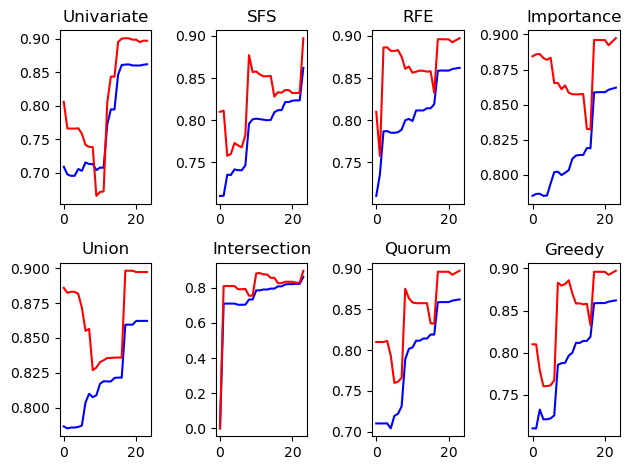

In [22]:
model = LogisticRegression(C=100, solver='liblinear', random_state=seed, n_jobs=n_cpu-1)
score_all_LR = get_scores(model, 'LR', feature_sets, feature_names)

In [23]:
results = pd.concat([results, score_all_LR], axis=1)
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

100%|██████████| 24/24 [18:17<00:00, 45.72s/it]


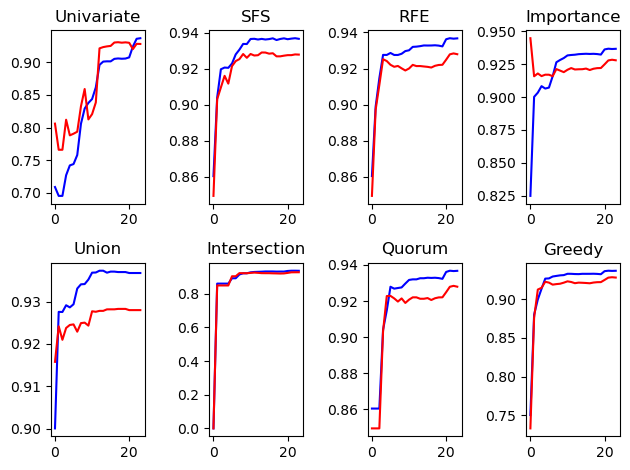

In [24]:
model = GradientBoostingClassifier(n_estimators=200, random_state=seed)
score_all_GB = get_scores(model, 'GB', feature_sets, feature_names)

In [25]:
results = pd.concat([results, score_all_GB], axis=1)
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

In [26]:
import tensorflow as tf
import tensorflow.keras as keras

def create_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(50, activation='relu', input_shape=(input_shape,)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy)
    return model

100%|██████████| 24/24 [1:58:28<00:00, 296.18s/it]


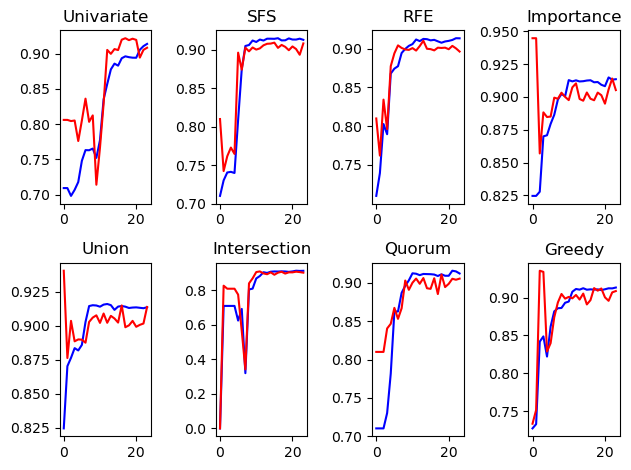

In [27]:
tf.random.set_seed(seed)
n_features = train_X.shape[1]

kf = StratifiedKFold(shuffle=True, random_state=seed)

score_all_NN = pd.DataFrame()
plt.subplots(2, 4)
for k, (feature_set, feature_name) in enumerate(zip(feature_sets, feature_names)):
    cv_score = []
    test_score = []
    for i in trange(n_features):
        cv = []
        if isinstance(feature_set[0], list):
            train_X2 = train_X[feature_set[i]].copy()
            if train_X2.empty:
                cv_score.append(0)
                test_score.append(0)
                continue
        else:
            train_X2 = train_X[feature_set[:i+1]].copy()
        model = create_model(train_X2.shape[1])
        for train_index, test_index in kf.split(train_X2, train_Y):
            x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
            y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

            model.fit(x_train_fold.values, y_train_fold.values,
                    epochs=15, batch_size=100,verbose=0)
            
            predict = model.predict(x_test_fold,verbose=0)
            predict = np.where(predict < 0.5, 0, 1)
            cv.append(f1_score(y_test_fold, predict))
        cv_score.append(np.mean(cv))

        model.fit(train_X2.values, train_Y.values,
                epochs=15, batch_size=100,verbose=0)
        if isinstance(feature_set[0], list):
            predict = model.predict(test_X[feature_set[i]],verbose=0)
        else:
            predict = model.predict(test_X[feature_set[:i+1]],verbose=0)
        predict = np.where(predict < 0.5, 0, 1)
        test_score.append(f1_score(test_Y, predict))

        del model, train_X2

    score_all_NN[f'cv_score_{feature_name}_NN'] = cv_score
    score_all_NN[f'test_score_{feature_name}_NN'] = test_score

    plt.subplot(2, 4, k+1)
    plt.title(feature_name)
    plt.plot(range(n_features), cv_score, color='blue', linestyle='-', label='CV Score')
    plt.plot(range(n_features), test_score, color='red', linestyle='-', label='Test Score')
plt.tight_layout()
plt.show()

In [28]:
results = pd.concat([results, score_all_NN], axis=1)
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

# Stopping Points

In [29]:
def MaxDelta(score):
    max_delta = 0
    index = len(score) - 1
    for i in range(len(score)-1, 0, -1):
        delta = score[i] - score[i-1]
        if delta > max_delta:
            max_delta = delta
            index = i

    return index

def MinPerfReq(score, tolerence):
    best_score = score[-1] * (1 - tolerence)
    index = len(score) - 1
    for i in range(len(score)-1, 0, -1):
        if score[i] < best_score:
            index = i+1
            break

    return index

def MaxScore(score, size, factor):
    best_performance = 0
    index = len(score) - 1
    for i in range(len(score)-1, 0, -1):
        current_size = size[i]
        adj_score = score[i] - (factor * current_size)
        if adj_score > best_performance:
            best_performance = adj_score
            index = i

    return index

In [30]:
tolerence = 0.03
factor = 0.03
stopping_points = {}
indices = []
for model_name in ['LR', 'GB', 'NN']:
    for feature_set, feature_name in zip(feature_sets, feature_names):
        cv_score = results[f'cv_score_{feature_name}_{model_name}'].to_list()
        test_score = results[f'test_score_{feature_name}_{model_name}'].to_list()
        if feature_name in ['Union', 'Intersection', 'Quorum']:
            subset_size = [len(i) for i in feature_set]
        else:
            subset_size = np.arange(1, n_features+1)
        stop1 = MaxDelta(cv_score)
        stop2 = MinPerfReq(cv_score, tolerence)
        stop3 = MaxScore(cv_score, subset_size, factor)

        for stop_name, index in zip(['MaxDelta', 'MinPerfReq', 'MaxScore'], [stop1, stop2, stop3]):
            stopping_points[f'{stop_name}_size_{feature_name}_{model_name}'] = subset_size[index]
            stopping_points[f'{stop_name}_cv_score_{feature_name}_{model_name}'] = cv_score[index]
            stopping_points[f'{stop_name}_test_score_{feature_name}_{model_name}'] = test_score[index]

stopping_points = pd.Series(stopping_points)
stopping_points

MaxDelta_size_Univariate_LR          13.000000
MaxDelta_cv_score_Univariate_LR       0.771896
MaxDelta_test_score_Univariate_LR     0.804716
MinPerfReq_size_Univariate_LR        16.000000
MinPerfReq_cv_score_Univariate_LR     0.846455
                                       ...    
MinPerfReq_cv_score_Greedy_NN         0.885891
MinPerfReq_test_score_Greedy_NN       0.893494
MaxScore_size_Greedy_NN               3.000000
MaxScore_cv_score_Greedy_NN           0.841920
MaxScore_test_score_Greedy_NN         0.935273
Length: 216, dtype: float64

In [31]:
stopping_points.to_csv(f'./Experiments/{dataset_name}/stopping_points.csv', header=False)

# Visualization

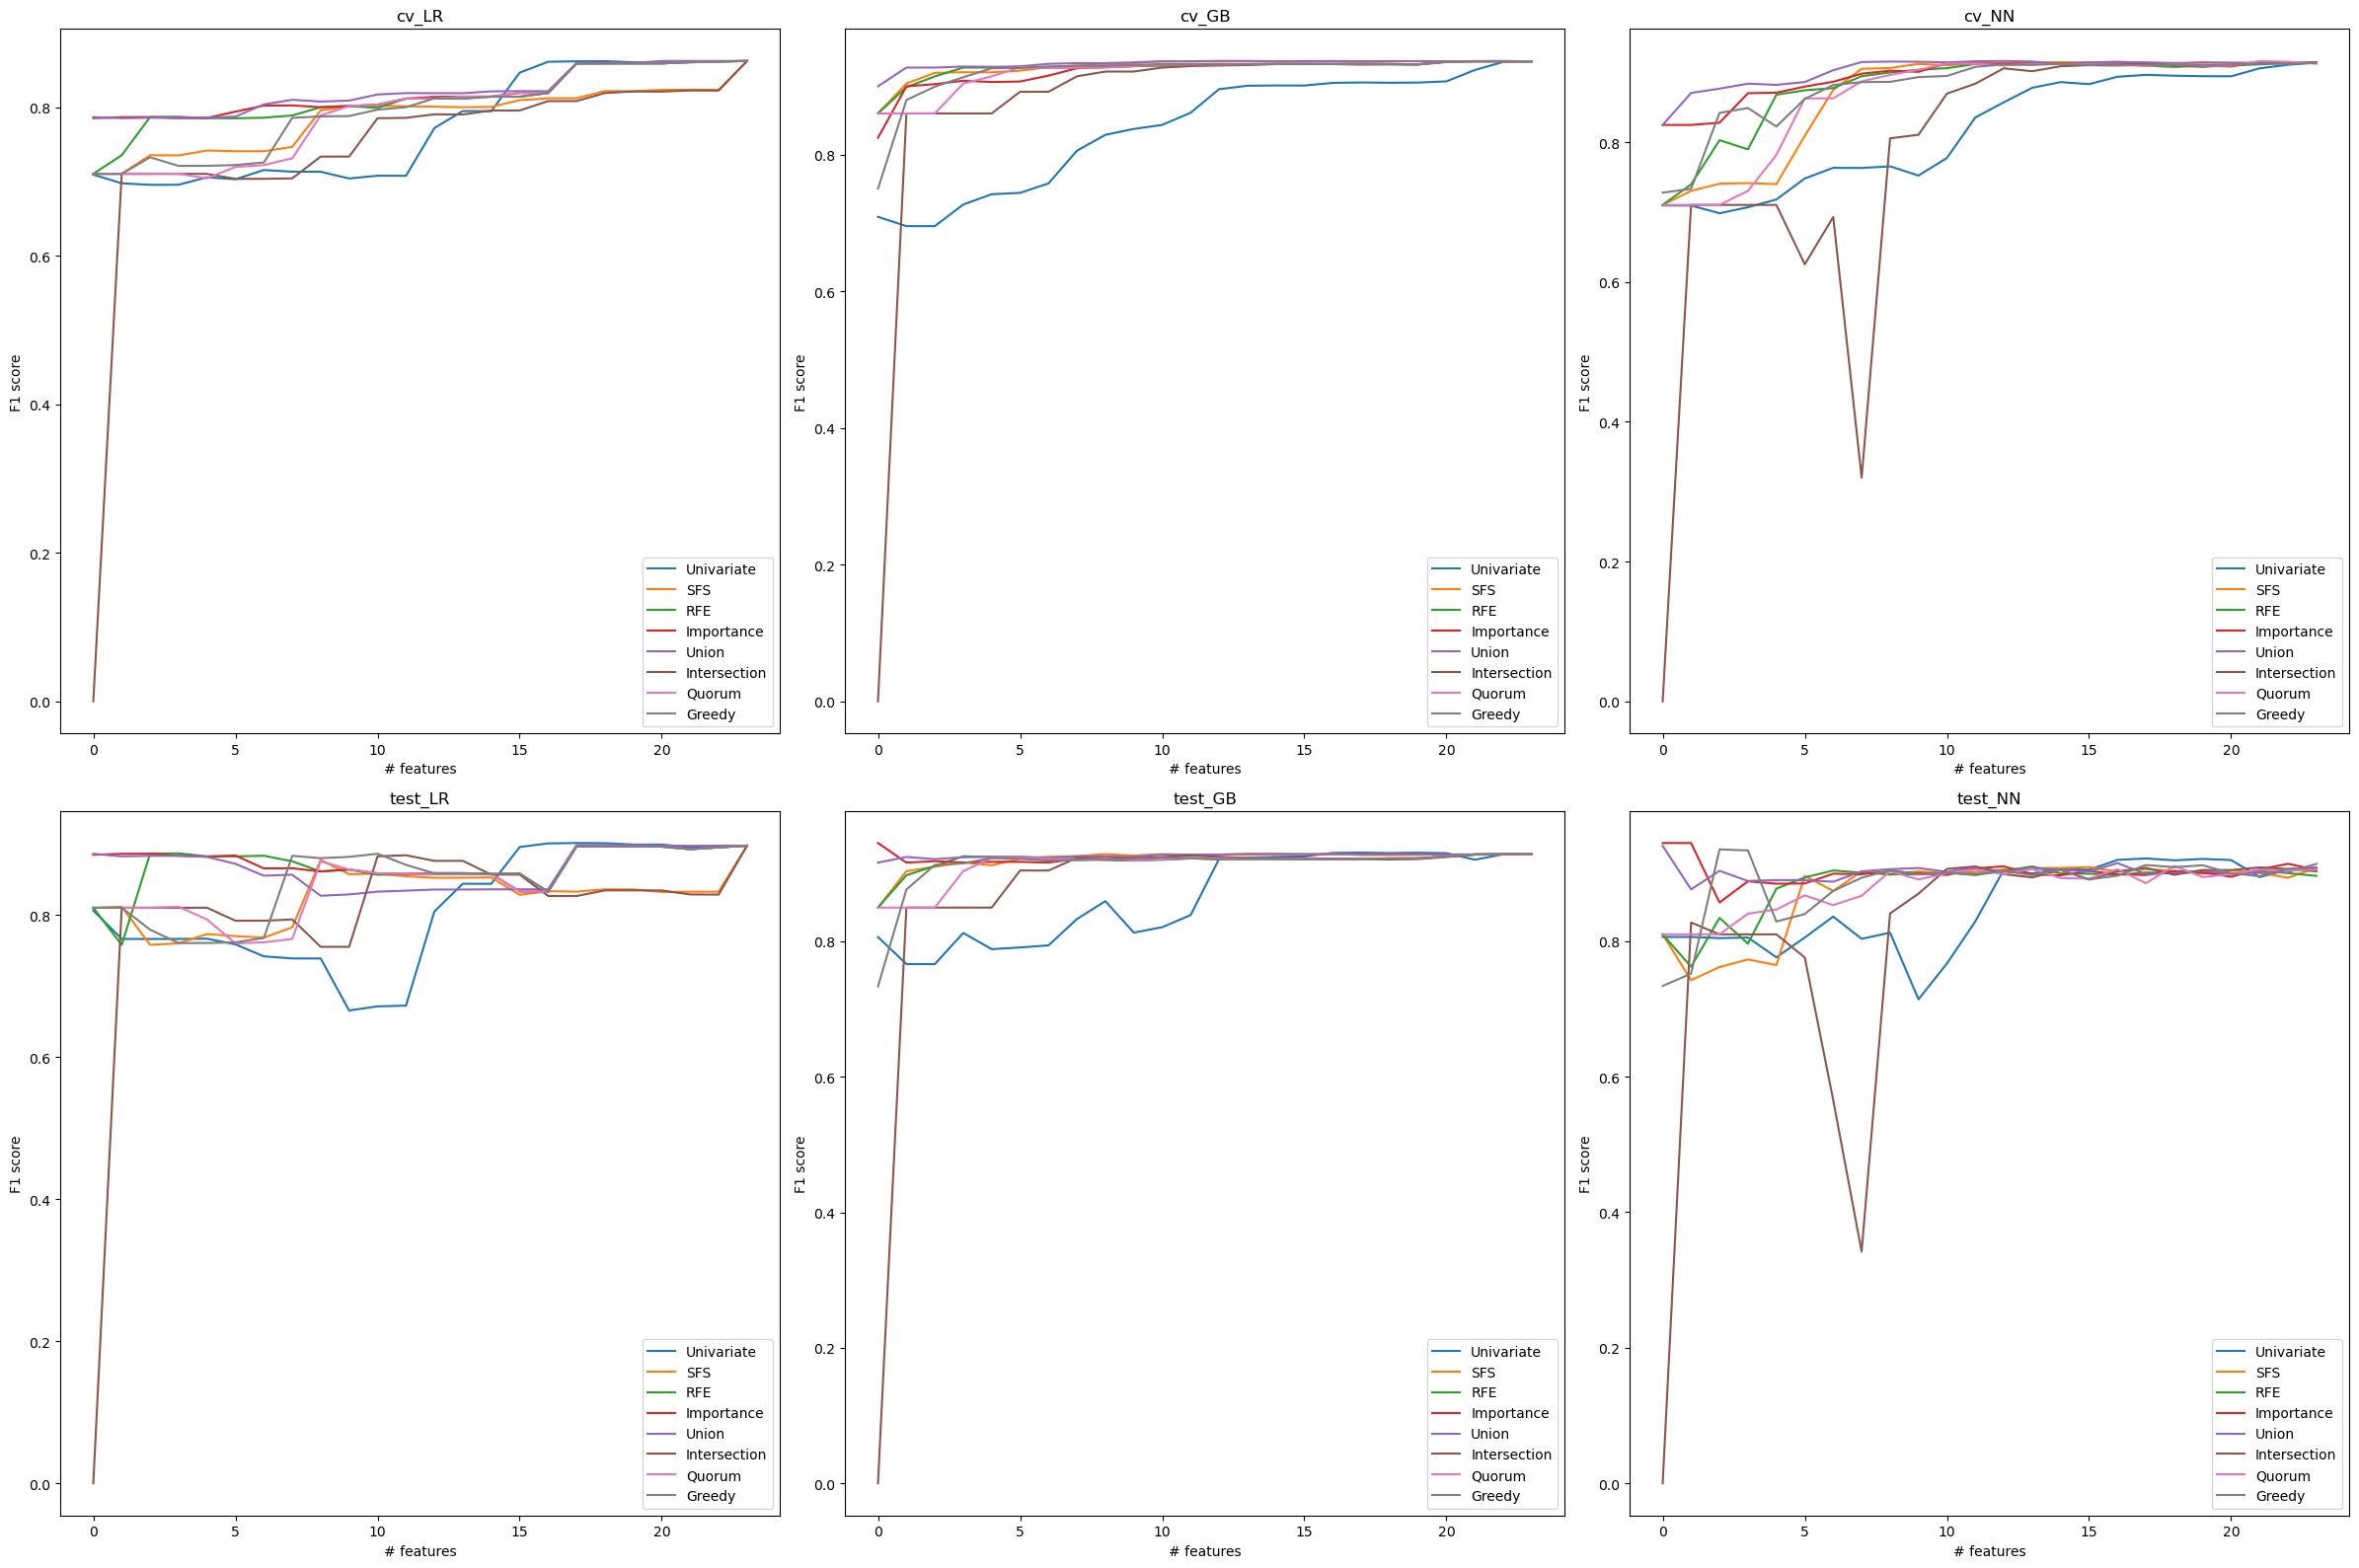

In [32]:
plt.subplots(2, 3, figsize=(24, 16))
for i, model_name in enumerate(['LR', 'GB', 'NN']):
    plt.subplot(2, 3, i+1)
    plt.title(f'cv_{model_name}')
    plt.xlabel('# features')
    plt.ylabel('F1 score')
    for feature_name in feature_names:
        plt.plot(range(n_features), results[f'cv_score_{feature_name}_{model_name}'], label=feature_name)
    plt.legend()
    plt.subplot(2, 3, i+4)
    plt.title(f'test_{model_name}')
    plt.xlabel('# features')
    plt.ylabel('F1 score')
    for feature_name in feature_names:
        plt.plot(range(n_features), results[f'test_score_{feature_name}_{model_name}'], label=feature_name)
    plt.legend()
plt.tight_layout()
plt.show()

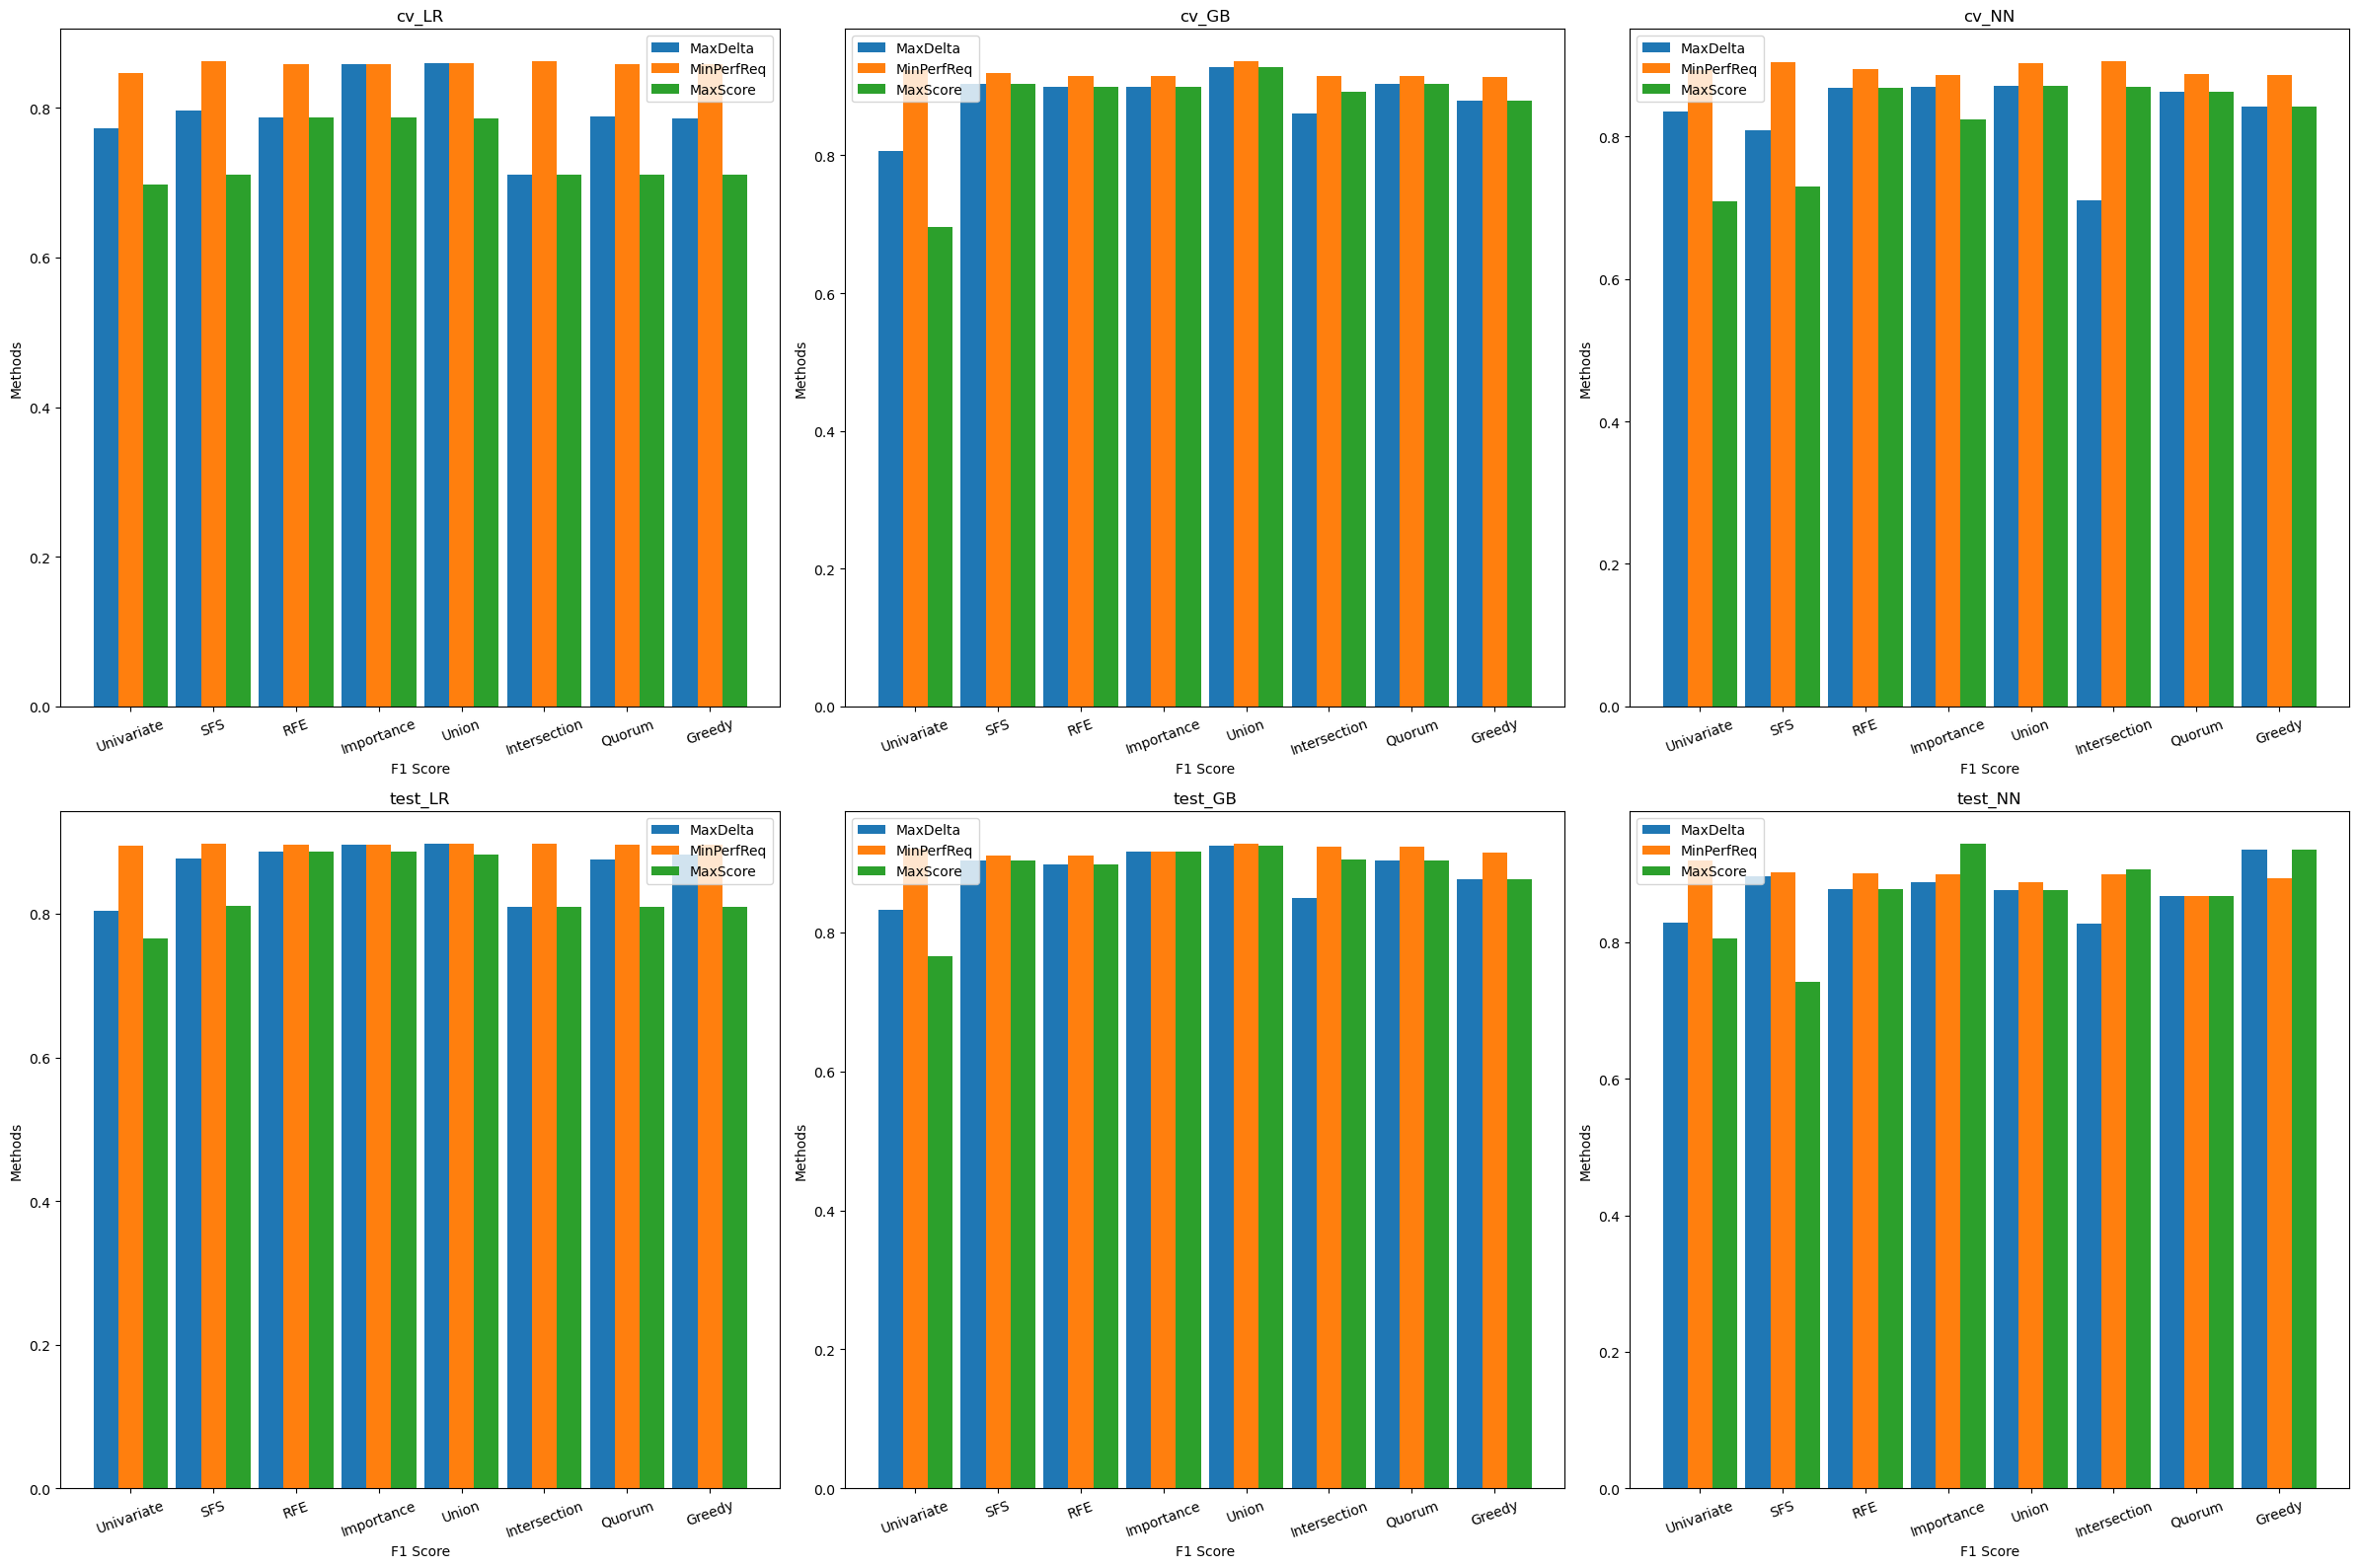

In [33]:
width=0.3
n = len(feature_names)
plt.subplots(2, 3, figsize=(24, 16))
for i, model_name in enumerate(['LR', 'GB', 'NN']):
    plt.subplot(2, 3, i+1)
    plt.title(f'cv_{model_name}')
    plt.xlabel('F1 Score')
    plt.ylabel('Methods')
    md = []
    mp = []
    ms = []
    for feature_name in feature_names:
        md.append(stopping_points[f'MaxDelta_cv_score_{feature_name}_{model_name}'])
        mp.append(stopping_points[f'MinPerfReq_cv_score_{feature_name}_{model_name}'])
        ms.append(stopping_points[f'MaxScore_cv_score_{feature_name}_{model_name}'])
    plt.bar(x=range(n), height=md, width=width, label='MaxDelta')
    plt.bar(x=[x+width for x in range(n)], height=mp, width=width, label='MinPerfReq')
    plt.bar(x=[x+width*2 for x in range(n)], height=ms, width=width, label='MaxScore')
    plt.xticks([x+width for x in range(n)], feature_names)
    plt.xticks(rotation=20)
    plt.legend()
    plt.subplot(2, 3, i+4)
    plt.title(f'test_{model_name}')
    plt.xlabel('F1 Score')
    plt.ylabel('Methods')
    md = []
    mp = []
    ms = []
    for feature_name in feature_names:
        md.append(stopping_points[f'MaxDelta_test_score_{feature_name}_{model_name}'])
        mp.append(stopping_points[f'MinPerfReq_test_score_{feature_name}_{model_name}'])
        ms.append(stopping_points[f'MaxScore_test_score_{feature_name}_{model_name}'])
    plt.bar(x=range(n), height=md, width=width, label='MaxDelta')
    plt.bar(x=[x+width for x in range(n)], height=mp, width=width, label='MinPerfReq')
    plt.bar(x=[x+width*2 for x in range(n)], height=ms, width=width, label='MaxScore')
    plt.xticks([x+width for x in range(n)], feature_names)
    plt.xticks(rotation=20)
    plt.legend()
plt.tight_layout()
plt.show()

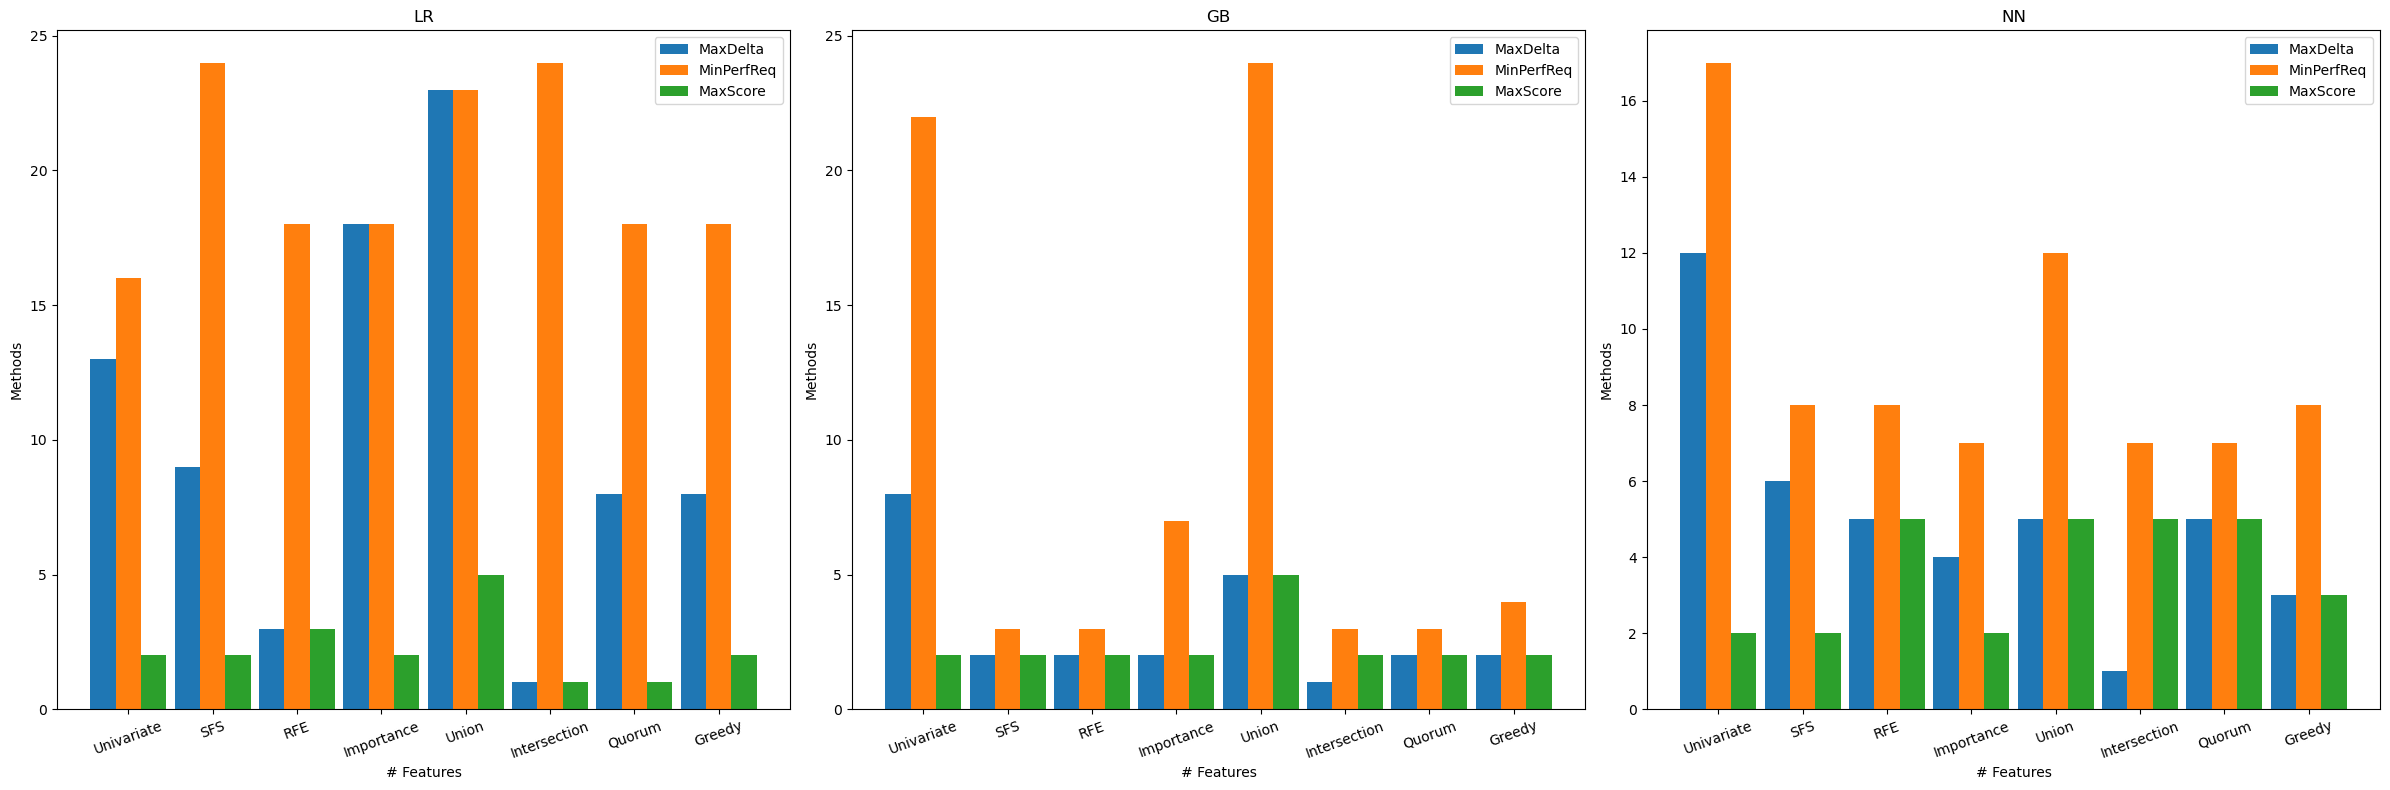

In [34]:
plt.subplots(1, 3, figsize=(24, 8))
for i, model_name in enumerate(['LR', 'GB', 'NN']):
    plt.subplot(1, 3, i+1)
    plt.title(f'{model_name}')
    plt.xlabel('# Features')
    plt.ylabel('Methods')
    md = []
    mp = []
    ms = []
    for feature_name in feature_names:
        md.append(stopping_points[f'MaxDelta_size_{feature_name}_{model_name}'])
        mp.append(stopping_points[f'MinPerfReq_size_{feature_name}_{model_name}'])
        ms.append(stopping_points[f'MaxScore_size_{feature_name}_{model_name}'])
    plt.bar(x=range(n), height=md, width=width, label='MaxDelta')
    plt.bar(x=[x+width for x in range(n)], height=mp, width=width, label='MinPerfReq')
    plt.bar(x=[x+width*2 for x in range(n)], height=ms, width=width, label='MaxScore')
    plt.xticks([x+width for x in range(n)], feature_names)
    plt.xticks(rotation=20)
    plt.legend()
plt.tight_layout()
plt.show()